In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [2]:
diamonds_df = pd.read_csv('diamonds.csv')

In [3]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


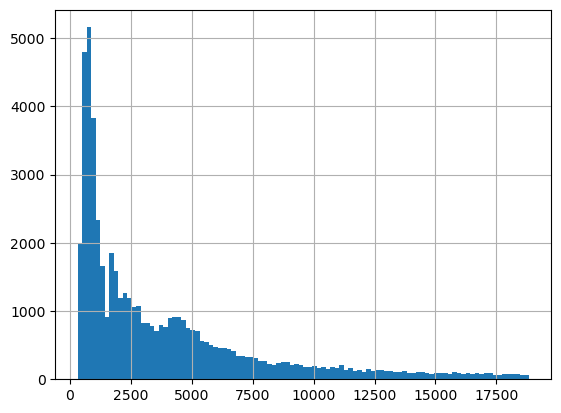

In [4]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [5]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [6]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [7]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [8]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [9]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

# Обучаем модель линейной регрессии

In [11]:
reg = LinearRegression().fit(X_train, y_train)

In [12]:
y_pred = reg.predict(X_test)

In [13]:
score = r2_score(y_pred, y_test)

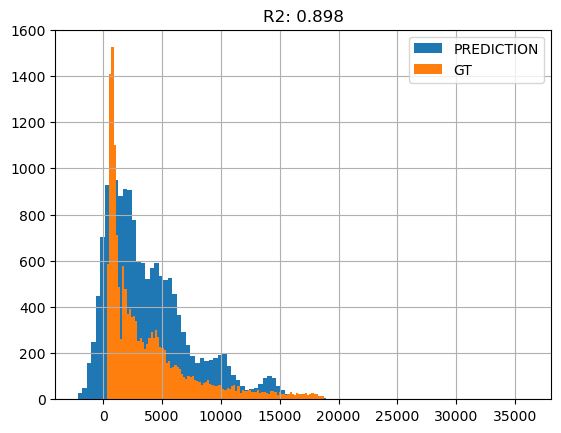

In [14]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

In [15]:
class MyReLU:
    def __init__(self, k = 0.01):
        self.k = k
        
    def forward(self, x):
        return np.where(x > 0, x, x * self.k)
    
    def backward(self, x, gradient):
        return gradient * np.where(x > 0, x > 0, self.k) 

In [16]:
class DenseLayer:
    def __init__(self, input_shape, output_shape, learning_rate= 0.000001):
        self.W = np.random.normal(0.0, np.sqrt(1.0 / float(input_shape)), (input_shape,output_shape))
        self.b = np.zeros(output_shape)
        self.learning_rate = learning_rate
    
    def forward(self, x):
        return x @ self.W + self.b
    
    def backward(self, x, gradient):
        gradient_x = gradient @ self.W.T
        gradient_W = x.T @ gradient
        gradient_b = gradient.mean(axis=0) * x.shape[0]
        self.W = self.W - self.learning_rate * gradient_W
        self.b = self.b - self.learning_rate * gradient_b
        return gradient_x

In [17]:
def squaredloss(y, y_target, gradient = False):
    if gradient:
        return 2 * (y - y_target)
    return np.square(y - y_target)

In [18]:
class MLPRegressor:
    def __init__(self, layers, loss_func = squaredloss):
        self.layers = layers
        self.loss_func = loss_func
        
    def forward(self, x):
        activation = x
        activated_layer = []
        for layer in self.layers:
            activated_layer.append(layer.forward(activation))
            activation = activated_layer[-1]
        return activated_layer
    
    def train(self, x, y):
        activated_layer = self.forward(x)
        layer_inputs = [x] + activated_layer
        output = activated_layer[-1]
        gradient = self.loss_func(output, y, True)
        for i, layer in reversed(list(enumerate(self.layers))):
            gradient = layer.backward(layer_inputs[i], gradient)
        return np.mean(self.loss_func(output, y))
    
    def predict(self, x):
        return self.forward(x)[-1]

# Проверяем модель MLP на выборке Diamonds

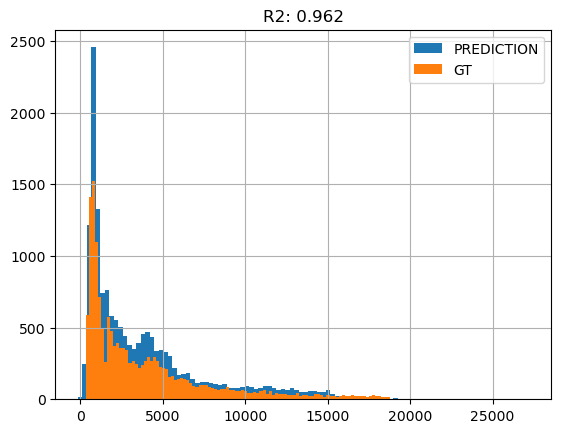

In [19]:
clf = MLPRegressor((DenseLayer(9, 190), MyReLU(), DenseLayer(190, 1),))

k = 60
splitter = int(y_train.shape[0]/k)
for epoch in range(10):
    for i in range(splitter):
        clf.train(X_train[i*k:i*k+k,], y_train[i*k:i*k+k,])
    
y_pred = clf.predict(X_test)
score = r2_score(y_pred, y_test)
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();